$\textbf{CNN for determining beam position for Hodoscope development}$
$\newline$

by Tyler Stuck

$\underline{Abstract}$
$\newline \text{   }$

In this work, a machine learning model was developed to predict the position where an incident beam impinges upon a scintillating crystal when given the total number of photons seen by a photomultiplier tube (PMT) array. The data used in this project was collected from Geant4 simulations of a new Hodoscope design currently being developed for the Facility for Rare Isotope Beams (FRIB) at Michigan State. The model was based upon that shown in assignment 03. However, the model in this project is for regression rather than classification.

$\underline{Introduction}$
$\newline \text{   }$
$\newline$

The current hodoscope used at FRIB consists of 32 CsI(Na) scintillating crystals that have a face of area 7.6 cm x 7.6 cm and depth of 5.1 cm. Each crystal is attached to a photomultiplier tube for reading out the produced photons. These 32 crystals are arranged in eight rows of four. The hodoscope reads out the total kinetic energy deposited by an implanted nuclei and, in conjunction with the ionization chamber, can be used for identification of different charge states [1]. 

$\newline$
An improved version of the hodoscope is currently being developed. CsI(Na) scintillating crystals of the same dimension will still be used. Now a trapezoidal light-guide consisting of PMMA (a type of transparent glass) and a $TiO_2$ (Simulations with different coatings are still ongoing) coating will be used to direct the produced light into a PMT array. This array consists of a four by four grid of silicon photomultiplier tubes each with a face area of 12 mm x 12 mm.

$\newline$
The total number of photons observed by the PMT array is dependent on where the incident beam impinges upon the scintillating crystal. If the beam were to impinge upon the edge of the crystal, the number of photons observed by the array would be less than that seen if the beam impinged upon the center of the crystal. The following method provided by [2] can be used to eliminate this beam position dependence.

$\newline$

$$ L(Z) = L_m (x, y, Z)C(x,y) $$

$\newline$
L(Z) is the output corrected for position (where Z is the proton number). $L_m$ is the original total photon data set, and C is the correcting function. $C(x,y)$ explicitly is the inverse of a function that fits the original photon data set (normalized to the lowest observed number of photons) based on x and y. C was able to be obtained for the new Hodoscope design based on Geant4 simulations, because Geant4 explicitly provides the beam's impact position. The current design of the improved Hodoscope does not include an explicit way of determining the location of where the beam impinges upon the scintillating crystals. However, by using the CNN proposed in this project, it has been shown that the model can accurately predict where the beam impinges upon the scintillator (average error of less than 1 mm in both the x and y position) based upon the number of photons observed by each of the PMTs in the PMT array.  

Google Colab Installation of mlinphysics

In [1]:
COLAB_FOLDER = 'MLP' # change as needed
GITHUB_USER  = 'hbprosper'
GITHUB_REPO  = 'mlinphysics'
GITHUB_FOLDERS = ['mlinphysics']
#------------------------------------------------------
try:
    from google.colab import drive
    drive.mount('/content/gdrive')
    print('\nGoogle Drive mounted\n')
    IN_COLAB = True
except:
    print('\nRunning locally\n')
    IN_COLAB = False

if IN_COLAB:
    MYDRIVE     = '/content/gdrive/MyDrive'
    GITHUB_BASE = 'https://raw.githubusercontent.com'
    MAIN        = 'refs/heads/main'
    GITHUB_PATH = f'{MYDRIVE}/{COLAB_FOLDER}'
    #------------------------------------------------------
    %cd {GITHUB_PATH}
    %rm -f {GITHUB_PATH}/clone2colab.ipynb
    !wget -q {GITHUB_BASE}/{GITHUB_USER}/{GITHUB_REPO}/{MAIN}/clone2colab.ipynb
    %run {GITHUB_PATH}/clone2colab.ipynb

    %pip install torch_geometric


Running locally



Importing the required modules

In [2]:
# standard system modules
import os, sys

# standard module for tabular data
import pandas as pd

# standard module for array manipulation
import numpy as np

# standard module for high-quality plots
import matplotlib as mp
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# standard research-level machine learning toolkit from Meta (FKA: FaceBook)
import torch
import torch.nn as nn
import torch.utils.data as dt

# module to access data in Hieracrchical Data Format (HDF or H5 format)
import h5py

# module to plot pixelized images
import imageio.v3 as im

# module to reimport Python modules
import importlib

# module for saving/loading serialized Python objects
import joblib

# module for shell utilities
import shutil

# ML in physics module
import mlinphysics.nn as mlp
import mlinphysics.utils.data as dat
import mlinphysics.utils.monitor as mon





Computational Device

In [3]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'\n\tAvailable device: {str(DEVICE):4s}\n')


	Available device: cpu 



$\underline{\text{Dataset Description}}$
$\newline \text{  }$

The datasets being used in this project were collected from a Geant4 simulation with a single crystal set-up of the new hodoscope design. Prior to conducting this simulation, the optimal angle region of the light-guide was found to be between 61 and 63 degrees or equivalently a distance between the scintillating crystal and the PMT array of 0.7 and 0.8 cm. Within this optimal region there is less than 0.5% variation of the total number of photons observed by the PMT array. The angle chosen for this simulation was 61.4 degrees or a distance of 0.755 cm between crystal and PMT array. The incident beam was $^{82}Se$ with a charge of 34 and beam energy of 140 MeV/u. The impinging position varied from -35mm to 35mm in steps of 2mm in both the x and y position. For each position combination, 1 event was conducted. The following data was collected: beam position and momentum, total produced photons via scintillation, and photons observed by each PMT of the PMT array. 

$\newline$

The number of photons observed by each PMT is normalized to the total number of photons observed by the PMT array.


$\underline{\text{Loading the data sets from files into python}}$

In [4]:
produced_photons_array = np.loadtxt('scan_CsI_Se82_master_produced_photon.dat')
absorbed_photons_array = np.loadtxt('scan_CsI_Se82_master_absorbed_photon.dat')
observed_photon_array_array = np.loadtxt('scan_CsI_Se82_master_observed_photon_array.dat')
observed_photon_total_array = np.loadtxt('scan_CsI_Se82_master_observed_photon_total.dat')
beam_position_array = np.loadtxt('scan_CsI_Se82_master_beam_position.dat')

#Converting the beam position array to mm (values are currently in cm)
beam_position_array = beam_position_array * 10

#Normalizing each PMT of the array to the total number of photons seen by the PMTs
normalized_PMT_array = np.zeros((1296,16))

for i in range (1296):
    for m in range (16):
        normalized_PMT_array[i][m] = observed_photon_array_array[i][m] / observed_photon_total_array[i]

# print (normalized_PMT_array.shape)

print(beam_position_array)


[[-35. -35. -80.   0.   0.  10.]
 [-35. -33. -80.   0.   0.  10.]
 [-35. -31. -80.   0.   0.  10.]
 ...
 [ 35.  31. -80.   0.   0.  10.]
 [ 35.  33. -80.   0.   0.  10.]
 [ 35.  35. -80.   0.   0.  10.]]


$\underline{\text{Separating the data sets into training, validating, and testing}}$

In [5]:
# generates a random sequence of integers from 0-1295
randomized_indices = np.random.permutation(1296)

training_indices = randomized_indices[0:648]
validation_indices = randomized_indices[648:972]
evaluating_model_indicies = randomized_indices[972:1296]

# training, validation, and evaluation photon datasets
training_photon_arrays = np.zeros((648,16))
validation_photon_arrays = np.zeros((324,16))
evaluation_photon_arrays = np.zeros((324,16))

# training, validation, and evaluation position datasets
training_position_arrays = np.zeros((648,2))
validation_position_arrays = np.zeros((324,2))
evaluation_position_arrays = np.zeros((324,2))

for i in range (648):
    # filling the training photon datasets
    training_photon_arrays[i][:] = normalized_PMT_array[training_indices[i]][:]

    # filling the training position datasets
    training_position_arrays[i][:] = beam_position_array[training_indices[i], 0:2]
    

for i in range (324):
    # filling the validation and evaluation (testing) photon datasets
    validation_photon_arrays[i][:] = normalized_PMT_array[validation_indices[i]][:]
    evaluation_photon_arrays[i][:] = normalized_PMT_array[evaluating_model_indicies[i]][:]

    # filling the validation and evaluation (testing) position datasets
    validation_position_arrays[i][:] = beam_position_array[validation_indices[i]][0:2]
    evaluation_position_arrays[i][:] = beam_position_array[evaluating_model_indicies[i]][0:2]

#reshaping the normalized data so that we have 432 images of 4x4 pixels
training_photons = training_photon_arrays.reshape(648, 4, 4)
validation_photons = validation_photon_arrays.reshape(324, 4, 4)
evaluating_photons = evaluation_photon_arrays.reshape(324, 4, 4)

print('training idices: ',training_indices[0])

print('training position', training_position_arrays[0][:])

print('training position shape: ', training_position_arrays.shape)

print ('training photons', training_photon_arrays[0][:])

###############################################

# REMEMBER THAT IF YOU WANT TO COMPARE THE INDEX THAT YOU GET WITH THE DATA SET,
# YOU MUST ADD +1 TO THE INDEX VALUE. THE POSSIBLE NUMBERS RANGE FROM 0 TO 1296-1 (1295)
# WHILE THE DATA SET STARTS FROM 1

###############################################


training idices:  805
training position [ 9. -9.]
training position shape:  (648, 2)
training photons [0.05896651 0.06161467 0.05738764 0.05318187 0.06377174 0.06587462
 0.06360438 0.05740753 0.0666716  0.06883622 0.06598367 0.06133895
 0.06557489 0.06679712 0.06410987 0.05887872]


$\underline{\text{Preparing the datasets so that they are in the shape of (N, C, H, W)}}$

$\newline$
N - number of images
$\newline$
C - number of input channels 
$\newline$
H - height of our image in pixels
$\newline$
W - width of our image in pixels 
$\\ \text{   }$
$\\$
Also changing the data types to tensors and then the type to float in order to match that of the biases

In [6]:
# Training photons
training_photons = training_photons.reshape(648, 1, 4, 4)
training_photons = torch.from_numpy(training_photons.astype(np.float32))
training_position_arrays = torch.from_numpy(training_position_arrays.astype(np.float32))

# Validation photons
validation_photons = validation_photons.reshape(324, 1, 4, 4)
validation_photons = torch.from_numpy(validation_photons.astype(np.float32))
validation_position_arrays = torch.from_numpy(validation_position_arrays.astype(np.float32))

# Evaluation photons
evaluating_photons = evaluating_photons.reshape(324, 1, 4, 4)
evaluating_photons = torch.from_numpy(evaluating_photons.astype(np.float32))
evaluation_position_arrays = torch.from_numpy(evaluation_position_arrays.astype(np.float32))



$\underline{\text{Model Description}}$
$\newline \text{ }$
$\newline$
The model used in this project is based on that shown in Assignment 03. The image consists of the normalized photon values in a four by four grid. This grid is then padded by 1 pixel with a value equal to that of the pixel it is next to. Pytorch's Conv2d function was used to convolve the input image. The padding was used to ensure that the convolved image had the same dimension as the original input. The first convolution takes in one input and outputs eight images, the second convolution takes in those eight images and outputs 16 images. The model uses Relu as its activation function (same activation function as that in [2] and in assignment 03). Similarly to assignment 03 the dropout function was used to ensure that the model is not overfitting the data. Unlike the model in assignment 03, the model in this project does not use the maxpool function or a softmax. The first change, is due to the small size of the image 4x4. The second change is due to our outputs being spanning a continuous range from -35 to 35 mm (of course the predicted outputs may deviate between these bounds) rather than discrete categories.

Once the final set of images has been obtained, the images are then flattened into a tensor. Once the data has been flattened a linear transformation (Pytorch's .Linear) is applied transforming the 256 inputs to 64 inputs. The Relu activation function is then once again used before a final linear transformation is applied transforming the 64 inputs into two outputs.

$\underline{\text{Configuration of the model}}$

In [7]:

model_name = 'impinging_position'

# choose whether to create or load a configuration file
load_existing_config = False

if load_existing_config:
    config = mlp.Config(f'{model_name}.yaml')
else:
    # create new config
    config = mlp.Config(model_name)

    n_images = 1296
    batch_size = 18
    n_iters_per_epoch = 36 # number of iterations per epoch
    train_size = n_iters_per_epoch * batch_size
    test_size = 324

    val_size = n_images - train_size - test_size

    config('batch_size', batch_size)
    config('train_size', train_size)
    config('test_size', test_size)
    config('val_size', val_size)

    config('monitor_step', 27) # set monitor training every n
    config('delete', True) # delete losses file before training, if True
    config('frac', 0.015) # save model if average loss decreases by more than frac percent

    config('n_epochs', 200)
    config('n_iters_per_epoch', n_iters_per_epoch)
    config('n_iterations', config('n_epochs') * config('n_iters_per_epoch'))

    config('n_steps', 4) # number of training steps
    config('n_iters_per_step', config('n_iterations') // config('n_steps'))
    
    config('base_lr', 1.e-3) # initial learning rate
    config('gamma', 0.8) # learning rate scale factor

    print(f'\nSave configuration to file {config.cfg_filename}\n')
    
    config.save()

print(config)



Save configuration to file runs/2025-12-02_1309/impinging_position_config.yaml

name: impinging_position
file:
  losses: runs/2025-12-02_1309/impinging_position_losses.csv
  params: runs/2025-12-02_1309/impinging_position_params.pth
  init_params: runs/2025-12-02_1309/impinging_position_init_params.pth
  plots: runs/2025-12-02_1309/impinging_position_plots.png
batch_size: 18
train_size: 648
test_size: 324
val_size: 324
monitor_step: 27
delete: true
frac: 0.015
n_epochs: 200
n_iters_per_epoch: 36
n_iterations: 7200
n_steps: 4
n_iters_per_step: 1800
base_lr: 0.001
gamma: 0.8



$\underline{\text{Getting our data turned into the proper data set so that it can be used with the data loaders}}$

In [8]:
importlib.reload(dat)

train_size = config('train_size')
val_size = config('val_size')
test_size = config('test_size')

# training dataset (this defines the empirical risk to be minimized)
print('training data')
train_data = dat.Dataset(training_photons, start = 0, end = train_size, targets = training_position_arrays)

# a random subset of the training data to check for overtraining
# by comparing with the empirical risk from the validation set

print('training data for validation')
train_data_val = dat.Dataset(training_photons, start = 0, end = train_size, targets = training_position_arrays, random_sample_size = val_size)

# validation dataset (for monitoring training)
print('validation data')
val_data = dat.Dataset(validation_photons, start = 0, end = val_size, targets = validation_position_arrays)

# test dataset
print('test data')
test_data = dat.Dataset(evaluating_photons, start = 0, end = test_size, targets = evaluation_position_arrays)

training data
Dataset
  shape of x: torch.Size([648, 1, 4, 4])
  shape of y: torch.Size([648, 2])

training data for validation
Dataset
  shape of x: torch.Size([324, 1, 4, 4])
  shape of y: torch.Size([324, 2])

validation data
Dataset
  shape of x: torch.Size([324, 1, 4, 4])
  shape of y: torch.Size([324, 2])

test data
Dataset
  shape of x: torch.Size([324, 1, 4, 4])
  shape of y: torch.Size([324, 2])



/home/tylerstuck/mlprojects/mlinphysics/mlinphysics/utils/data.py:122: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  tmp = torch.tensor(data[start:end])
/home/tylerstuck/mlprojects/mlinphysics/mlinphysics/utils/data.py:130: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(data[start:end])
/home/tylerstuck/mlprojects/mlinphysics/mlinphysics/utils/data.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(targets[start:end])
/home/tylerstuck/mlprojects/mlinphysics/mlinphysics/utils/data.py:147: UserWarning: To

$\underline{\text{Now we include the data loaders}}$

In [9]:
print('train data loader')
train_loader = dt.DataLoader(train_data, batch_size = config('batch_size'), shuffle = True)

print('train data loader for validation')
train_loader_val = dt.DataLoader(train_data_val, batch_size = len(train_data_val))

print('validation data loader')
val_loader = dt.DataLoader(val_data, batch_size = len(val_data))

print('test data loader')
test_loader = dt.DataLoader(test_data, batch_size = len(test_data))

train data loader
train data loader for validation
validation data loader
test data loader


$\underline{\textbf{Build the model}}$


In [10]:
class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, padding = 1, dropout = 0.08):
        super().__init__()

        kernel_size = 2 * padding + 1

        self.conv1 = nn.Conv2d(in_channels = in_channels, out_channels = out_channels, 
                               kernel_size = kernel_size, stride = 1, padding = padding, padding_mode = 'replicate')
        
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu(x)
        x = self.dropout(x)
        return x
    
class BeamPositionIdentifier(mlp.Model):
    def __init__(self, image_size = 4, channels = (1, 8, 16), padding = 1, n_outputs = 2):
        super().__init__()

        # number of convolutional layers
        self.nlayers = len(channels) - 1

        #building convolution layers
        self.convs = nn.ModuleList(
            [ConvBlock(channels[i], channels[i+1], padding)
             for i in range(self.nlayers)])
        
        # computing size after convolutions
        final_image_size = image_size
        ninputs = channels[-1] * (final_image_size**2)

        # Regression (Rather than using maxpool as we want to predict where the beam impinges upon the scintillating crystal (x,y) )
        self.regressor = nn.Sequential(
            nn.Flatten(), # Fllatens a contiguous range of dims into a tensor
            nn.Linear(ninputs, 64), # a linear transformation from 256 (16*16 inputs) to 64 outputs
            nn.ReLU(), # non linear function
            nn.Linear(64, n_outputs) # linear function that transforms 64 to 2 outputs (x,y)
        )


    def forward(self, x):
        for conv in self.convs:
            x = conv(x)
        return self.regressor(x)

$\underline{\text{Instantiate model}}$

In [11]:
importlib.reload(mlp)

model = BeamPositionIdentifier().to(DEVICE)
print(model)
print()

print('number of parameters: ', mlp.number_of_parameters(model))
print()

BeamPositionIdentifier(
  (convs): ModuleList(
    (0): ConvBlock(
      (conv1): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), padding_mode=replicate)
      (relu): ReLU()
      (dropout): Dropout(p=0.08, inplace=False)
    )
    (1): ConvBlock(
      (conv1): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), padding_mode=replicate)
      (relu): ReLU()
      (dropout): Dropout(p=0.08, inplace=False)
    )
  )
  (regressor): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=256, out_features=64, bias=True)
    (2): ReLU()
    (3): Linear(in_features=64, out_features=2, bias=True)
  )
)

number of parameters:  17826



$\underline{\text{Mean Squared Error Loss function}}$

$\newline$
Using the MSE rather than the Average cross entropy loss since we are using regression rather than classification

In [12]:
class MeanSquaredErrorLoss():
    def __init__(self):
        self.loss_function = nn.MSELoss()
    def __call__(self, outputs, targets):
        return self.loss_function(outputs, targets)

$\underline{\text{Instantiate training objects}}$

$\newline$
1. optimizer
$\newline$
2. scheduler
$\newline$
3. objective

In [13]:
optimizer = torch.optim.Adam(model.parameters(), lr = config('base_lr'))

scheduler = mlp.get_steplr_scheduler(optimizer, config)

objective = mlp.Objective(model, MeanSquaredErrorLoss())

number of milestones:          3

Step | Milestone | LR
-----------------------------
   0 |         0 | 1.0e-03   
-----------------------------
   1 |      1800 | 8.0e-04   
   2 |      3600 | 6.4e-04   
   3 |      5400 | 5.1e-04   

number of iterations:           7200



$\underline{\text{Defining accuracy}}$

$\newline$
Since the output of the model is continuous values, rather than the discrete categories as with assignment 03 the model's accuracy must be redefined. The distance between the predicted and the true value will be used for as the accuracy. The function "accuracy" takes the outputs from the model and the target values and spits out the average of the discrepancy between these two vectors. So for example, if (0.0, 0.1) as is the output and (0.0, 0.0) as the true value for one run and, only consider one run, the accuracy function would output (0.0) for the discrepancy in x and (0.1) for the discrepancy in y. The average discrepancy is what is reported.

In [14]:
def accuracy(outputs, targets):
    
    # vector_distance = targets - outputs
    # distance = torch.sqrt(torch.sum(vector_distance**2))

    abs_discrepancy = torch.abs(targets - outputs)

    x_discrepancy = abs_discrepancy[:, 0].mean()
    y_discrepancy = abs_discrepancy[:, 1].mean()
    
    return x_discrepancy, y_discrepancy

$\underline{\text{Defining the Trainer}}$

In [15]:
def train(objective, optimizer, scheduler, train_loader, train_small_loader, val_loader, config):
    
    # get configuration info
    lossfile = config('file/losses')
    paramsfile = config('file/params')
    step = config('monitor_step')
    delete = config('delete')
    frac = config('frac')
    nepochs = config('n_epochs')
    niters = config('n_iterations')

    # instantiate objects taht saves MSE losses to a csv file for realtime monitoring

    losswriter = mon.LossWriter(niters, lossfile, step = step, delete = delete, frac = frac, model = objective.model, paramsfile = paramsfile)

    # instantiate learning rate step scheduler
    lrscheduler = mlp.LRStepScheduler(optimizer, scheduler)

    # ---------------------------------------
    # training loop
    # ---------------------------------------
    ii = -1

    for epoch in range (nepochs):
        for x, y in train_loader:
            ii += 1

            # set mode to training so that training-specific
            # operations such as dropout, etc., are enabled.
            objective.model.train()

            # clear all gradients
            optimizer.zero_grad()

            # compute empirical risk
            R = objective(x,y)

            # compute gradients
            R.backward()

            # take one step downhill in the empirical risk landscape
            optimizer.step()

            # check wheter to update learning rate
            lrscheduler.step()

            # I'm alive printout
            if (ii % step == 0) or (ii == niters -1):
                # compute average losses on training and validation data
                t_loss = mlp.compute_avg_loss(objective, train_small_loader)
                v_loss = mlp.compute_avg_loss(objective, val_loader)
                # return current learning rate
                lr = lrscheduler.lr()
                # update loss file
                losswriter(ii, t_loss, v_loss, lr, epoch)



		learning rate:  1.000e-03
      1782| 24.76%|00:00:02/00:00:08| 669.7 it/s|        49|3.675e+00|3.935e+00|
		learning rate:  8.000e-04
      3591| 49.89%|00:00:05/00:00:05| 667.3 it/s|        99|1.958e+00|1.950e+00|
		learning rate:  6.400e-04
      5373| 74.64%|00:00:08/00:00:02| 668.4 it/s|       149|1.520e+00|1.459e+00|
		learning rate:  5.120e-04
      7199|100.00%|00:00:10/00:00:00| 668.5 it/s|       199|1.005e+00|1.138e+00|


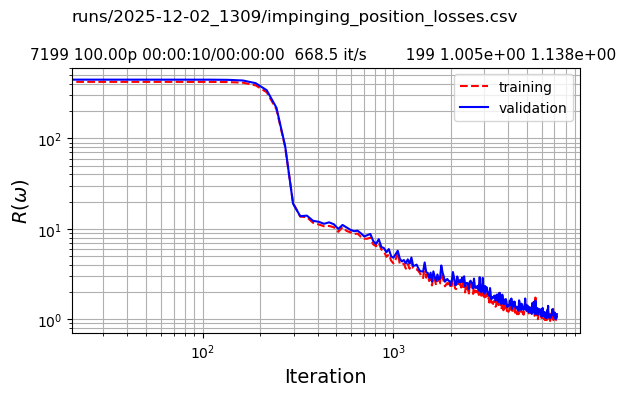

In [16]:
importlib.reload(mlp)
importlib.reload(mon)

train(objective, optimizer, scheduler, train_loader, train_loader_val, val_loader, config)

monitor = mon.Monitor(config('file/losses'))
#Occasionally this does not show the monitor plot, so I am saving the image, then plotting in the next cell
monitor.plot()
plt.savefig('monitor.png')



In [17]:
# Uncomment if the image in the cell above is not showing

# monitor_image = mpimg.imread('monitor.png')
# plt.imshow(monitor_image)
# plt.show()


$\underline{\text{Compute accuracy on test set}}$

In [18]:
model.load(config('file/params'))

test_x, test_y = next(iter(test_loader))

y_pred = model(test_x)

#Since acc is a tuple with 2 tensors (accuracy of x and accuracy of 1)
acc = accuracy(y_pred, test_y)

x_accuracy = acc[0]
x_accuracy = x_accuracy.detach().numpy()
y_accuracy = acc[1]
y_accuracy = y_accuracy.detach().numpy()

print('Average discrepancy on x (mm) : ', x_accuracy)
print('Average discrepancy on y (mm) : ', y_accuracy)

Average discrepancy on x (mm) :  0.8075745
Average discrepancy on y (mm) :  0.87336326


$\underline{\text{Plots of Predicted and Test data (X)}}$

In [19]:
# Converting test_y and y_pred into numpy arrays
test_y = test_y.detach().numpy()
y_pred = y_pred.detach().numpy()

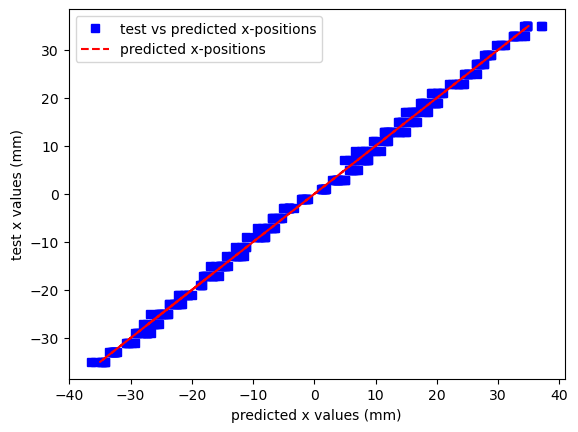

In [20]:
# print('shape of test_y', test_y.shape)
# print('test_y[:][0]', test_y[:,0])
# print('test_y', test_y)

plt.plot(y_pred[:, 0], test_y[:, 0], 'bs', label = 'test vs predicted x-positions')
plt.plot(test_y[:, 0], test_y[:, 0], 'r--', label  = 'predicted x-positions')
plt.legend()
plt.xlabel("predicted x values (mm)")
plt.ylabel("test x values (mm)")

plt.savefig('beam_x_position_graph.png')


In [21]:
# Uncomment if the cell above is not showing an image

# x_beam_position_image = mpimg.imread('beam_x_position_graph.png')
# plt.imshow(x_beam_position_image)
# plt.show()

$\underline{\text{Plots of Predicted and Test data (Y)}}$

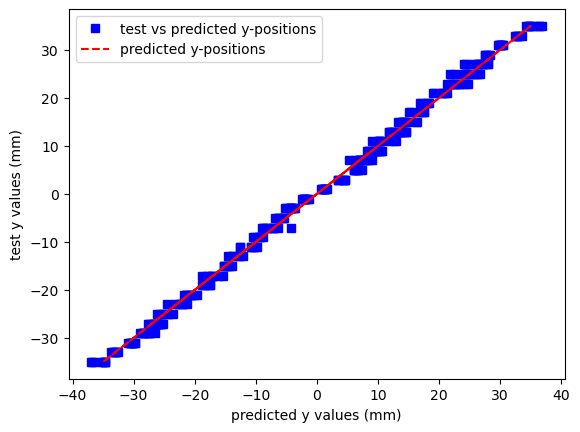

In [22]:
# print('shape of test_y', test_y.shape)
# print('test_y[:][0]', test_y[:,1])
# print('test_y', test_y)

plt.plot(y_pred[:, 1], test_y[:, 1], 'bs', label = 'test vs predicted y-positions')
plt.plot(test_y[:, 1], test_y[:, 1], 'r--', label  = 'predicted y-positions')
plt.legend()
plt.xlabel("predicted y values (mm)")
plt.ylabel("test y values (mm)")

plt.savefig('beam_y_position_graph.png')

In [23]:
# Uncomment if the cell above is not showing an image

# y_beam_position_image = mpimg.imread('beam_y_position_graph.png')
# plt.imshow(y_beam_position_image)
# plt.show()

$\underline{Summary}$
$\newline$

The model is able to accurately predict the location where the beam impinges upon the scintillator. The average discrepancy between the x and y predicted positions and test positions was less than 1 mm. This distance is also less than the step size that was used for the simulation. Based on the two figures we can also see that the predicted locations fit the test values well.

$\underline{\text{References and AI acknowledgement}}$
$\newline \text{ }$
[1] Hodoscope documentation at FRIB: https://wikihost.frib.msu.edu/S800Doc/doku.php?id=detectors
$\newline \text{ }$
[2] Method for removing position dependence of measured scintillation: https://iopscience.iop.org/article/10.1088/1748-0221/20/04/P04025/pdf


Chatgpt was used to occassional diagnose errors that might have occured, i.e type issues occasional spelling mistakes. It was also was used to help modify assigment 03 to be for regression rather than classification. Spcifically the self regressor function and not using the maxpool and softmax functions.



Github link where the dataset can be found:
https://github.com/TylerStuckFSU/MLP_project